# Calculate synthetic photometry for a given spectrum and filter

In [1]:
import specphot as sp
from astropy.io import fits, ascii
import astropy.table as Table
import numpy as np
import matplotlib.pyplot as plt
pretty_plot_params = {'font.size': 18, 
                     'text.usetex': True, 
                     'font.family': 'STIXGeneral',
                     'xtick.top': True,
                     'ytick.right': True,
                     'xtick.major.size': 10.,
                     'xtick.minor.size': 5.,
                     'xtick.major.width': 1.5,
                     'xtick.minor.width': 1.,
                     'ytick.major.size': 10.,
                     'ytick.minor.size': 5.,
                     'ytick.major.width': 1.5,
                     'ytick.minor.width': 1.,
                     'xtick.direction': 'in',
                     'ytick.direction': 'in',
                     'xtick.minor.visible': True,
                     'ytick.minor.visible': True}
plt.rcParams.update(pretty_plot_params)

In [2]:
spec_file = '../data/jades-gdn2-v3_prism-clear_1181_23167_jades_23167-goods-n-mediumhst.spec.fits'
with fits.open(spec_file) as hdul:
    t = Table.Table(hdul[1].data)

# Get the wavelength and flux arrays
wavelength = np.array(t['wave'])
flux = np.array(t['flux'])
flux_err = np.array(t['err'])
# If you have a mask, you can load it here. Otherwise, create a mask of zeros.
mask = np.zeros_like(flux)

# Create a Spectrum object
# Note that internally, wavelength and flux units are converted to AA and 
# erg/s/cm^2/AA, respectively.
spec = sp.Spectrum(wavelength=wavelength, 
                   flux=flux, 
                   flux_err=flux_err, 
                   mask=mask,
                   wavelength_units='um',
                   flux_units='uJy')

In [3]:
# Load the filter transmission curve
f = ascii.read('../data/f200w.par')
filter_wavelength = np.array(f['col1'])
filter_transmission = np.array(f['col2'])

# Calculate the synthetic photometry
f_f200w, e_f200w, lam_center = spec.pass_through_filter(filter_wavelength=filter_wavelength,
                                            filter_transmission=filter_transmission,
                                            filter_wavelength_units='AA',
                                            photometry_units='erg/s/cm^2/AA')

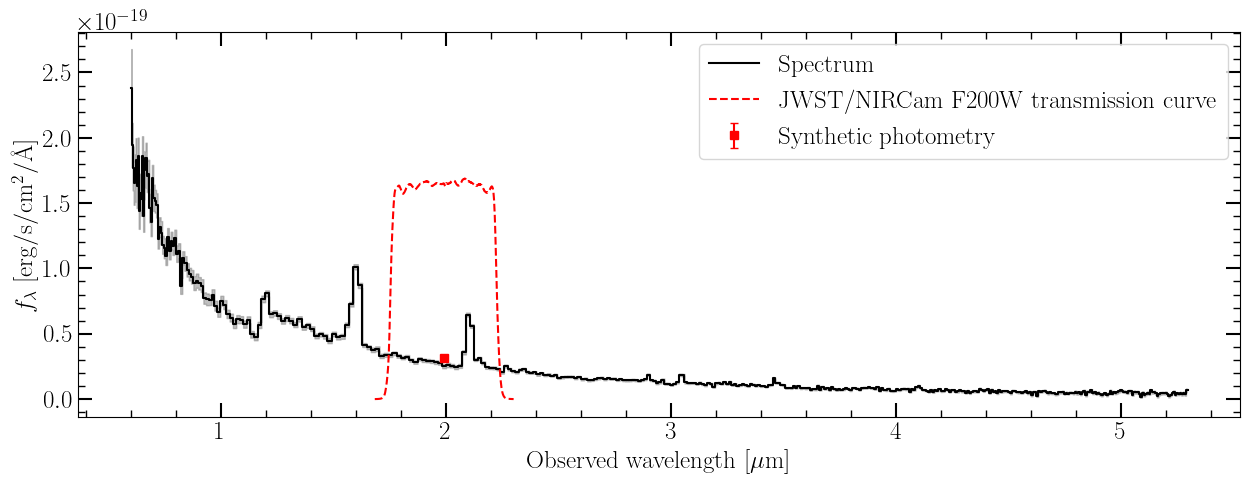

In [5]:
# Plot the spectrum, the filter transmission curve, and the synthetic photometry
fig, ax = plt.subplots(figsize=(15,5))
ax.step(spec.wavelength*1e-4, spec.flux, color='black', where='mid', label='Spectrum')
ax.fill_between(spec.wavelength*1e-4, spec.flux-spec.flux_err, spec.flux+spec.flux_err, color='gray', alpha=0.5, step='mid')

ax.plot(filter_wavelength*1e-4, 30*filter_transmission*np.nanmedian(spec.flux), color='red', label='JWST/NIRCam F200W transmission curve', ls='--')
ax.errorbar(lam_center*1e-4, f_f200w, yerr=e_f200w, fmt='s', color='red', capsize=3, label='Synthetic photometry')
ax.set_xlabel('Observed wavelength [$\\rm \mu m$]')
ax.set_ylabel('$f_{\lambda}$ [$\\rm erg/s/cm^2/\AA$]')
ax.legend()
